### GBDT (Gradient Boosting Decision Tree)

#### Gradient Boosted Trees

In [1]:
#Necessary Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('heart_disease.csv')

In [3]:
data.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
data.drop('Unnamed: 0', axis = 1, inplace =True)

In [5]:
# Dataset analysis/stats using describe method.
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
# Checking for missing values
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [7]:
# Just find correlation of features vs target using corrwith
data.drop('target', axis = 1).corrwith(data.target)

age        -0.225439
sex        -0.280937
cp          0.433798
trestbps   -0.144931
chol       -0.085239
fbs        -0.028046
restecg     0.137230
thalach     0.421741
exang      -0.436757
oldpeak    -0.430696
slope       0.345877
ca         -0.391724
thal       -0.344029
dtype: float64

### Visualize the correlation

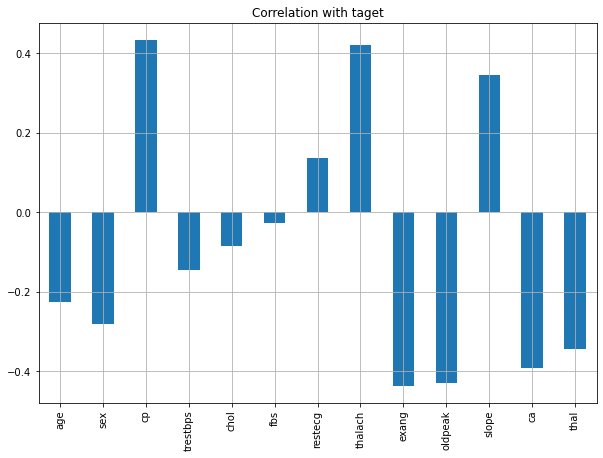

In [8]:
data.drop('target', axis = 1).corrwith(data.target).plot(kind = 'bar', grid = True, figsize =(10,7), 
                                                         title ='Correlation with taget')
plt.show()

#### Let's work on feature selection and see if that can help us building better model.

### Model building using SelectionPercentile features

In [10]:
from sklearn.feature_selection import SelectPercentile, chi2

when we apply chi2, we get p-value for all features. Based on the p-value, it will select top 80% of feature.

Ex- if pvalue<0.05, it will reject null hypothesis. Default null hypothesis is, there is no relation b/w feature and target

In [11]:
# instantiate SelectPercentile and fit (feature, Label)
x = data.drop(['target'], axis = 1)
y = data.target

SPercentile = SelectPercentile(score_func = chi2, percentile=80)

SPercentile = SPercentile.fit(x,y)

In [12]:
# Seperate the features to check p-values
cols = SPercentile.get_support(indices=True)  #  to return index number instead of boolean
print('Feature Index = ', cols)

features = x.columns[cols]
print('Features = ',list(features))

Feature Index =  [ 0  1  2  3  4  7  8  9 10 11]
Features =  ['age', 'sex', 'cp', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'slope', 'ca']


In [13]:
df_scores = pd.DataFrame({'features' : x.columns, 'Chi2Score' : SPercentile.scores_, 'pvalue' : SPercentile.pvalues_})
df_scores.sort_values(by = 'Chi2Score', ascending= False)

,features,Chi2Score,pvalue
7,thalach,188.320472,7.395102e-43
9,oldpeak,72.644253,1.552583e-17
11,ca,66.440765,3.605677e-16
2,cp,62.598098,2.534982e-15
8,exang,38.914377,4.428074e-10
4,chol,23.936394,9.957148e-07
0,age,23.286624,1.395673e-06
3,trestbps,14.823925,1.180286e-04
10,slope,9.804095,1.741237e-03
1,sex,7.576835,5.912318e-03


Let's print the top 80% features

In [15]:
# Create subset of selected features
x = data[features]

y = data.target

In [16]:
## Import libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()
x_scaler = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaler, y, test_size = 0.3, random_state= 42)

## GradientBoostingClassifier

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report, accuracy_score

In [19]:
# write one function and call as many as times to check accuracy_score of different models
def metric_score(clf, x_train, x_test, y_train, y_test, train = True):
    if train:
        y_pred = clf.predict(x_train)
        
        print("\n===================Train Result============================")
        
        print(f"Accuracy Score:{accuracy_score(y_train,y_pred) * 100:.2f}%")
    
    elif train == False:
        pred = clf.predict(x_test)
        
        print("\n===================Test Result============================")
        
        print(f"Accuracy Score:{accuracy_score(y_test, pred) * 100:.2f}%")
        
        print("\n \n Test Classification Report \n", classification_report(y_test, pred, digits = 2))  

In [20]:
# Initiate GradientBoostingClassifier
gbdt_clf = GradientBoostingClassifier()

# Train the model
gbdt_clf.fit(x_train, y_train)

GradientBoostingClassifier()

In [22]:
# Call the function and pass dataset to check train and test score

metric_score(gbdt_clf, x_train, x_test, y_train, y_test, train = True)   # this is for Training Score

metric_score(gbdt_clf, x_train, x_test, y_train, y_test, train = False)   # this is for Test Score


===================Train Result============================
Accuracy Score:100.00%

===================Test Result============================
Accuracy Score:83.52%

 
 Test Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.83      0.82        41
           1       0.86      0.84      0.85        50

    accuracy                           0.84        91
   macro avg       0.83      0.83      0.83        91
weighted avg       0.84      0.84      0.84        91



#### Let's try if we can improve the performance of our model using parameter tuning

## Hyperparameter tuning

In [24]:
grid_param = {
    'max_depth' :range(4,8),
    'min_samples_split' : range(2,8,2),
    'learning_rate' : np.arange(0.1,0.3)
}

In [25]:
grid = GridSearchCV(GradientBoostingClassifier(),param_grid = grid_param)

grid.fit(x_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': array([0.1]),
                         'max_depth': range(4, 8),
                         'min_samples_split': range(2, 8, 2)})

In [26]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 2}

In [29]:
gbdt_clf = GradientBoostingClassifier(
     max_depth= 4, min_samples_split=2,learning_rate=0.1)

gbdt_clf.fit(x_train,y_train)

GradientBoostingClassifier(max_depth=4)

In [30]:
# Call the function and pass dataset to check train and test score

metric_score(gbdt_clf, x_train, x_test, y_train, y_test, train = True)   # this is for Training Score

metric_score(gbdt_clf, x_train, x_test, y_train, y_test, train = False)   # this is for Test Score


===================Train Result============================
Accuracy Score:100.00%

===================Test Result============================
Accuracy Score:84.62%

 
 Test Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83        41
           1       0.88      0.84      0.86        50

    accuracy                           0.85        91
   macro avg       0.84      0.85      0.85        91
weighted avg       0.85      0.85      0.85        91



### You can still tune the parameter with different range and try to improve the score